In [171]:
%matplotlib notebook
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from tabulate import tabulate
from sklearn.manifold import MDS
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sklearn
import math
import os

from src.internal_library import *
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, HuberRegressor, ElasticNet
from sklearn.linear_model import RANSACRegressor, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mateosarja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
N_INGREDIENTS = 500

recipes, ingredients, ratings = import_rated_recipes(N_INGREDIENTS)

edge_list, edge_matrix = build_edges(ingredients)

ingredient_list = np.sort(ingredients['ingredient'].unique())

print(f'recipes : {recipes.shape}')
print(f'ingredients : {ingredients.shape}')
print(f'ratings : {ratings.shape}')
print(f'ingredient_list : {ingredient_list.shape}')
print(f'edge_matrix : {edge_matrix.shape}')

/Users/mateosarja/Documents/Uni/Year 4/FYP/FYP/src/internal_library.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ingredients.drop_duplicates(inplace=True)


recipes : (194698, 481)
ingredients : (1343294, 3)
ratings : (30308, 3)
ingredient_list : (481,)
edge_matrix : (481, 481)


<IPython.core.display.Javascript object>


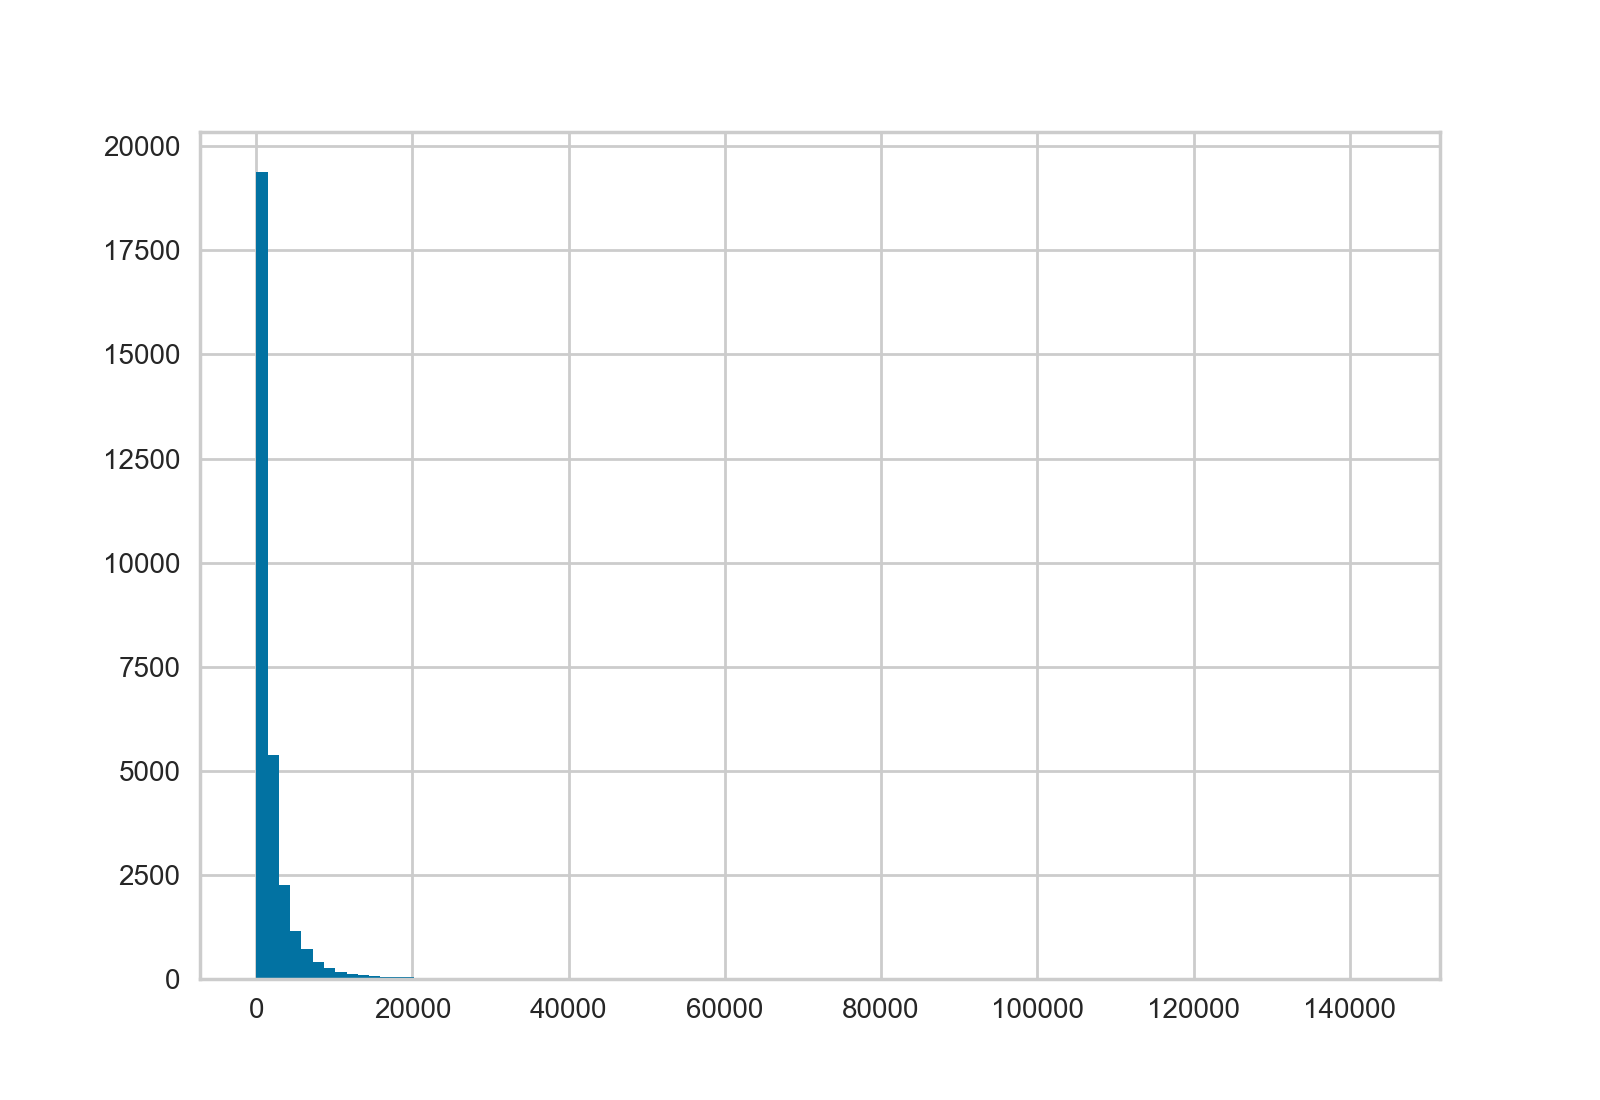

In [116]:
plt.figure()

plt.hist(np.multiply(ratings['make_again'],ratings['review_count']), bins=100)

plt.show()

<IPython.core.display.Javascript object>


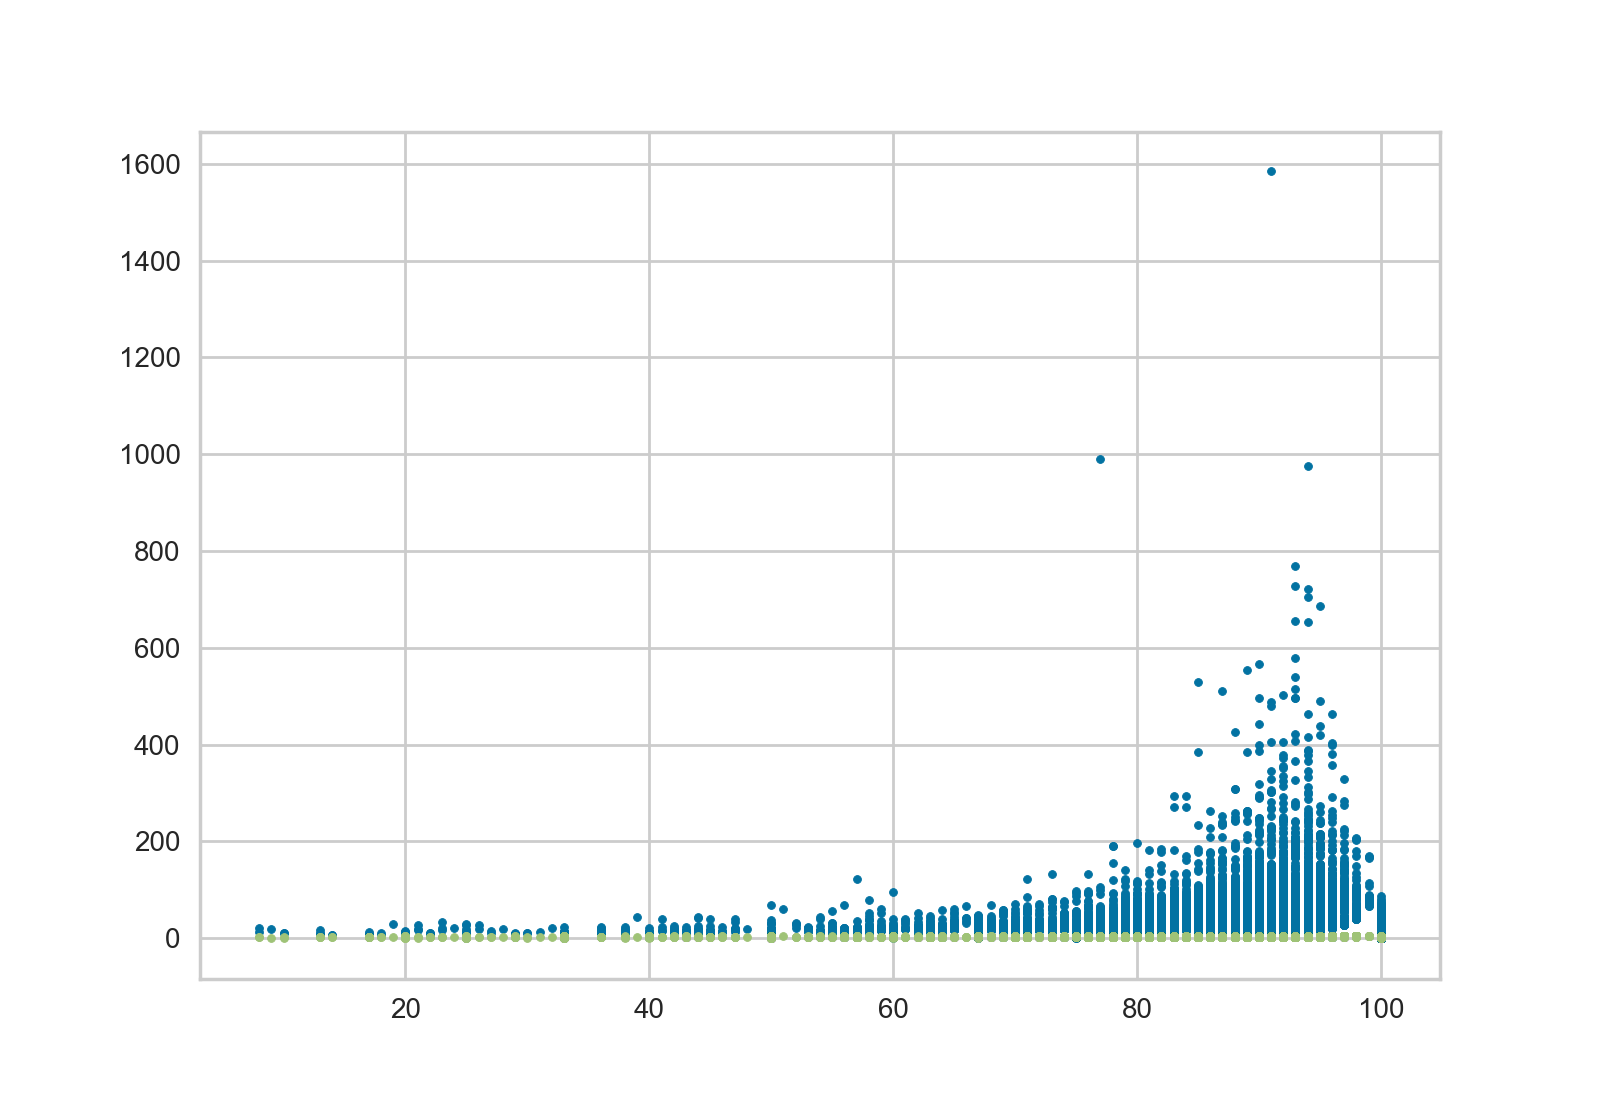

In [45]:
plt.figure()
plt.scatter(ratings['make_again'], ratings['review_count'], s=8)
plt.scatter(ratings['make_again'], ratings['rating'], s=8)
plt.show()

## Normalizing data

In [201]:
rated_recipes = recipes[recipes.index.isin(ratings.index)]

X = rated_recipes.sort_index()
ing_per_recipe_threshold = 1
X = X[X.sum(axis=1)>=ing_per_recipe_threshold]
print(X.shape)

y = ratings['review_count'].sort_index()

y = y[y.index.isin(X.index)]

allrec = 'allrecipes'
epi = 'recipes/food'

y_allrec = y[y.index.str.contains(allrec)]
y_epi = y[y.index.str.contains(epi)]

print(y_allrec.shape)
print(y_epi.shape)

(30308, 481)
(0,)
(30308,)


In [202]:
from sklearn.preprocessing import robust_scale, QuantileTransformer

qt = QuantileTransformer(n_quantiles=300, output_distribution='uniform')
review_count_qt = pd.DataFrame(qt.fit_transform(y_epi.values.reshape(-1, 1)))
# ar.index = y_allrec.index
# ec = pd.DataFrame(qt.transform(y_epi.values.reshape(-1, 1)))
review_count_qt.index = y_epi.index

# review_count_qt = pd.concat([ar, ec])
review_count_qt.name = 'review_count_qt'

# ar = (y_allrec.apply(np.log10)/np.log10(y_allrec.sum()))* 1/0.609639
# ar.index = y_allrec.index
review_count_log = (y_epi.apply(np.log10)/np.log10(y_epi.sum())) * 1/0.609639
review_count_log.index = y_epi.index

# review_count_log = pd.concat([ar, ec])
review_count_log.name = 'review_count_log'

# ar = y_allrec/y_allrec.sum()
# ar.index = y_allrec.index
review_count_sum = y_epi/y_epi.sum()
review_count_sum.index = y_epi.index

# review_count_sum = pd.concat([ar, ec])*10000
review_count_sum.name = 'review_count_sum'

### Make Again %

In [203]:
y_ma = ratings['make_again'][ratings['review_count']>14]
# y_ma = ratings['make_again']
# y_ma = y_ma[y_epi>14]

qt = QuantileTransformer(n_quantiles=20, output_distribution='uniform')
y_ma_qt = pd.DataFrame(qt.fit_transform(y_ma.values.reshape(-1, 1)))[0]
y_ma_qt.name = 'y_ma_qt'
y_ma_qt.index = y_ma.index
print(y_ma_qt.shape)

(12419,)


## Testing Models

In [208]:
fn_to_name = {SVR : 'SVR',
            LinearRegression: 'L-Regression', 
            Ridge : 'Ridge',
            RidgeCV : 'RidgeCV',
            BayesianRidge: 'B-Ridge',
            Lasso : 'Lasso',
            HuberRegressor : 'H-Regressor',
            RandomForestRegressor : 'RandomForest', 
            ElasticNet: 'E-Net', 
            RANSACRegressor: 'RANSACRegressor',
            MLPRegressor: 'MLP'
            }

# rated_recipes = recipes[recipes.index.isin(ratings.index)]

ys = [review_count_log, review_count_qt[0], review_count_sum, y_ma, y_ma_qt]
# ys = [y_ma, y_ma_qt]


regr_stats = { 'Data' : ['Min', 'Max', 'MSE', 'MAE', 'R2']}
top_coefs = {}

# plt.figure()
# for idx, y in enumerate(ys):
y = ys[4]
y.sort_index()
#     print(y.flatten().shape)
X = X[X.index.isin(y.index)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

models = [LinearRegression, Ridge, RidgeCV, HuberRegressor, MLPRegressor]
#     models = [MLPRegressor]

for model in tqdm(models):

    reg = model()

    reg = reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    minimum = y_test.min()
    maximum = y_test.max()
    mse = round(mean_squared_error(y_test, y_pred),5)
    mae = round(mean_absolute_error(y_test, y_pred),5)
    r2 = round(r2_score(y_test, y_pred),5)

    ## Test ys
#         plt.subplot(len(ys),1,idx+1)
# #         plt.bar(range(reg.coef_.shape[0]), reg.coef_)
#         plt.scatter(y_test, y_pred)
# #         top_coefs[f'{y.name}_max'] = np.argsort(reg.coef_)[:10]
# #         top_coefs[f'{y.name}_min'] = np.argsort(-reg.coef_)[:10]
#         regr_stats[y.name] = [minimum, maximum, mse, mae, r2]
    ## Test Models
#     if model != RANSACRegressor:
#         top_coefs[f'{fn_to_name[model]}_max'] = np.argsort(reg.coef_)[:10]
#         top_coefs[f'{fn_to_name[model]}_min'] = np.argsort(-reg.coef_)[:10]
    regr_stats[fn_to_name[model]] = [minimum, maximum, mse, mae, r2]
    
print(tabulate(regr_stats, headers='keys', tablefmt='fancy_grid', numalign="right"))
top_coefs = {k: ingredient_list[v] for k, v in top_coefs.items()}
plt.show()





  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [00:00<00:01,  3.93it/s]



 60%|██████    | 3/5 [00:01<00:00,  3.43it/s]



 80%|████████  | 4/5 [00:05<00:01,  1.40s/it]



100%|██████████| 5/5 [00:12<00:00,  2.44s/it]

╒════════╤════════════════╤═══════════╤═══════════╤═══════════════╤═══════════╕
│ Data   │   L-Regression │     Ridge │   RidgeCV │   H-Regressor │       MLP │
╞════════╪════════════════╪═══════════╪═══════════╪═══════════════╪═══════════╡
│ Min    │      0.0108605 │ 0.0108605 │ 0.0108605 │     0.0108605 │ 0.0108605 │
├────────┼────────────────┼───────────┼───────────┼───────────────┼───────────┤
│ Max    │              1 │         1 │         1 │             1 │         1 │
├────────┼────────────────┼───────────┼───────────┼───────────────┼───────────┤
│ MSE    │    1.04771e+21 │    0.0855 │   0.08416 │       0.08794 │   0.16711 │
├────────┼────────────────┼───────────┼───────────┼───────────────┼───────────┤
│ MAE    │    8.59989e+08 │   0.24966 │   0.24839 │        0.2521 │   0.32819 │
├────────┼────────────────┼───────────┼───────────┼───────────────┼───────────┤
│ R2     │   -1.27784e+22 │  -0.04275 │  -0.02641 │      -0.07256 │   -1.0382 │
╘════════╧════════════════╧═══════════╧═

In [160]:
for k in top_coefs.keys():
    print(k)
    print(top_coefs[k])
    print()

make_again_max
['nuts' 'cream of mushroom soup' 'rotini' 'italian salad dressing'
 'frosting' 'double cream' 'venison' 'flax seeds' 'phyllo dough'
 'tamarind paste']

make_again_min
['cream of chicken soup' 'white cake' 'taco seasoning mix' 'eggnog'
 'spaghetti sauce' 'cornflakes' 'steak sauce' 'dressing' 'pickels'
 'egg substitute powder']

y_ma_qt_max
['nuts' 'cream of mushroom soup' 'italian salad dressing' 'rotini'
 'frosting' 'double cream' 'cheese blend' 'phyllo dough' 'flax seeds'
 'pumpkin puree']

y_ma_qt_min
['cream of chicken soup' 'white cake' 'eggnog' 'cornflakes'
 'taco seasoning mix' 'spaghetti sauce' 'ameri cheese' 'dressing'
 'vanilla yogurt' 'pickels']



In [ ]:
# y_allrecipes = y_onesource.mask(y_onesource>2000, 2000)

print(y_onesource2[y_onesource2<4].shape)
print(y_onesource[y_onesource<4].shape)


<IPython.core.display.Javascript object>


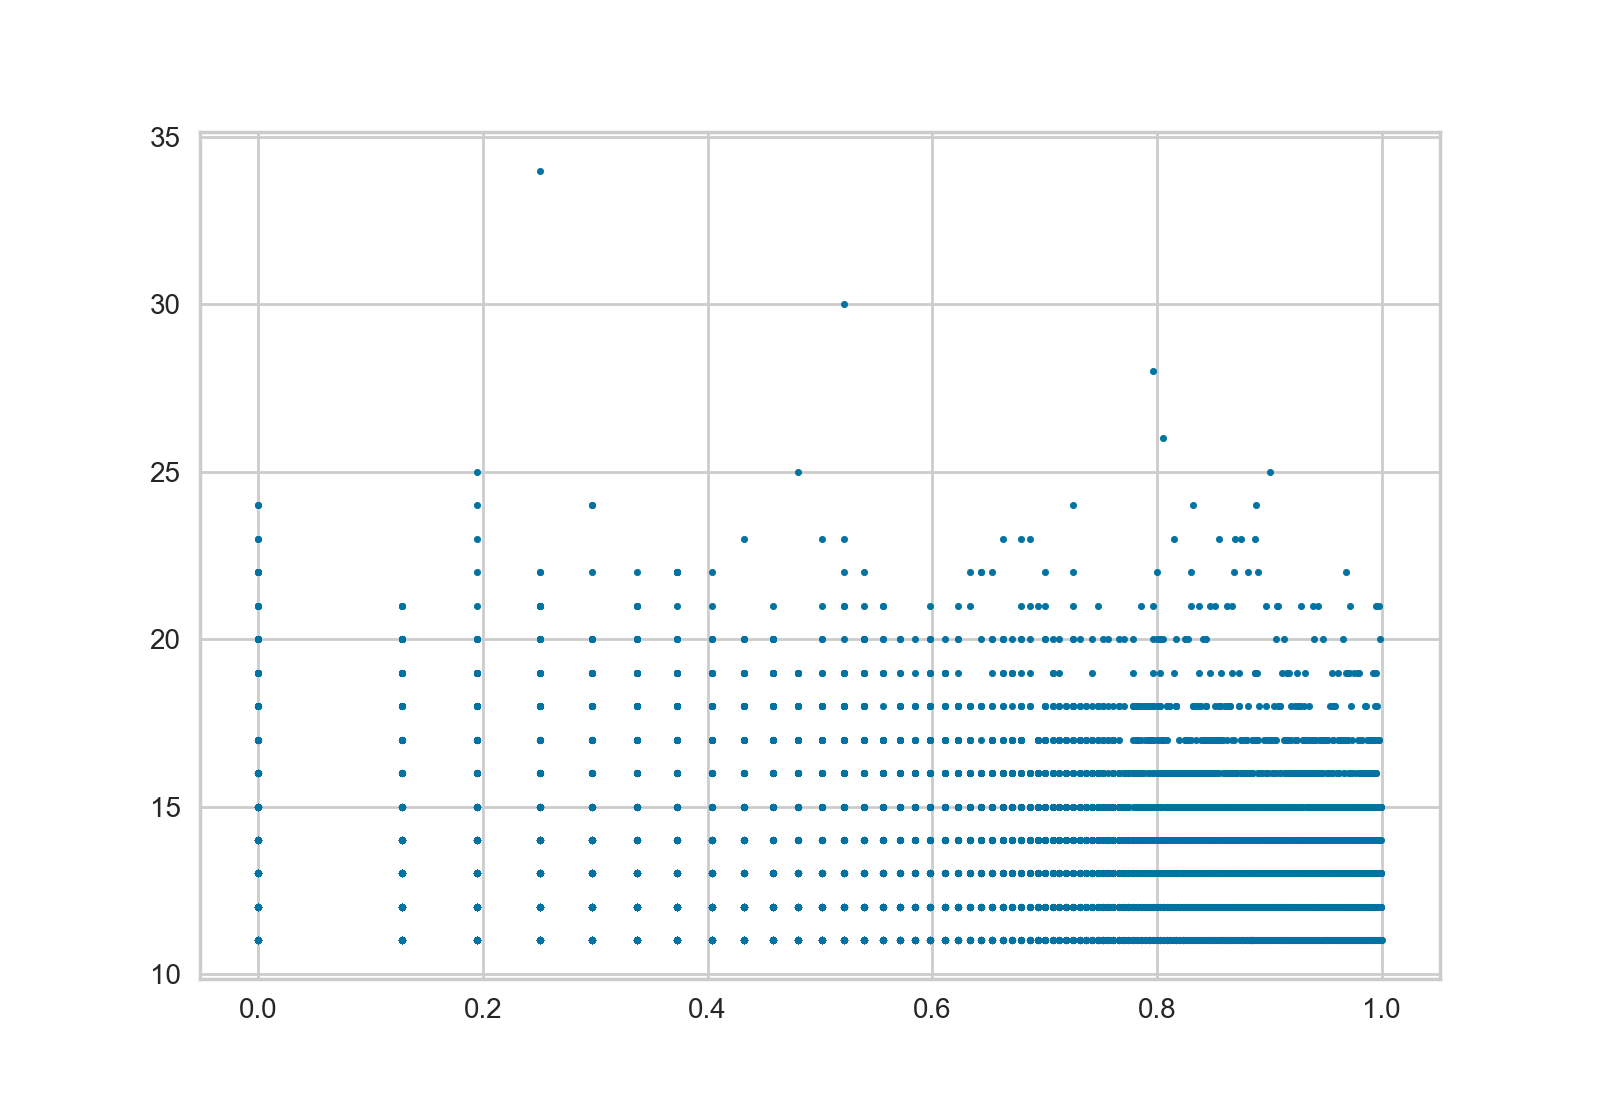

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [31]:
plt.figure()
plt.scatter(review_count_qt[rated_recipes.sum(axis=1)>10], rated_recipes[rated_recipes.sum(axis=1)>10].sum(axis=1), s=5)
# plt.scatter(review_count_qt, rated_recipes.sum(axis=1), s=1)
plt.show()

In [23]:
rated_recipes[rated_recipes.sum(axis=1)>5]

ingredient,acorn squash,active dry yeast,agave nectar,allspice,almond butter,almond extract,almond flour,almond milk,almond paste,almonds,...,white wine vinegar,wholemeal flour,wild rice,wonton wrappers,worcestershire sauce,xanthan gum,yellow cake,yellow squash,yogurt,zucchini
url,,,,,,,,,,,,,,,,,,,,,
/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
/recipes/food/views/-burnt-carrots-and-parsnips-56390131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/recipes/food/views/-california-roll-salad-12246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/recipes/food/views/-candy-corn-frozen-citrus-cream-pops-368770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/recipes/food/views/-candy-corn-pumpkin-blondies-51254510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/recipes/food/views/-cannoli-ice-cream-sandwiches-242004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [226]:
df = pd.read_csv('dataset/one_out/iou.csv', index_col=0)
df.groupby('og_neighbor')['neighbor'].value_counts().sum()

685